# Classifying Handwritten Digits with Python
## Josh Hess

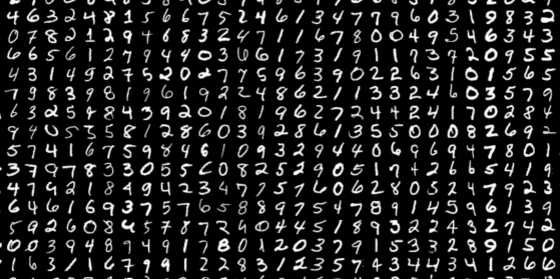

This notebook is my analysis and modeling of the MNIST handwritten digit dataset using the programming language Python. This notebook will follow this structure:

**TODO:** Add a table of contents with links here.

## 1.) Load in libraries and data

First, let's start by loading in our data science libraries, as well as our MNIST data:
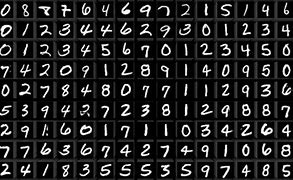
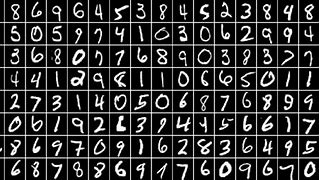

In [ ]:
# Load in libraries
import pandas as pd
import matplotlib.pyplot as plt
from random import seed  # For reproducing training cycles

# Load in data
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# Set seed for reproducability
seed(123)

In [ ]:
# Glance at structure of data
train.head()

As we can see above, the data consists of many individual image files. Each row represents an image. There are 784 columns:

1. `label`: This column represents what number is the drawn digit in the image.
2. `pixelA`: Represents the $(A-1)$th pixel in the image. For example, `pixel234` represents the 233rd pixel in the image. Each pixel can have a value from 0 to 255 inclusive which represents the "intensity" of that pixel.

Let's see what our MNIST data actually *looks* like. Below, let's randomly sample 3 individual images. We'll convert the pixels to a $28\times28$ matrix and display it as an image, along with its label:

In [ ]:
# Define a function to display an image with its label
def display_image(index, images, labels):
    image = images.iloc[index].values.reshape(28, 28)  # Reorganize pixels into a 28x28 matrix
    label = labels.iloc[index]                         # Extract label for image from training data

    # Plot the pixels as a 28x28 image
    plt.imshow(image, cmap = 'gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Define images and labels
labels = train['label']
images = train.drop(columns=['label'])

print(type(images))

# Display first 3 images
for i in range(3):
    display_image(i, images, labels)

Normally, we'd have an extensive phase of exploratory data analysis (EDA) at this point, but our data has no missing values or incorrect labels according to MNIST. So we are good to begin with preprocessing our data and preparing for modeling.

## 2.) Preprocessing our data

We are good to begin preparing our data for the modeling process. Here is an outline of the steps we will follow for preprocessing:

1. Separate Features and Labels:
   - Split the dataset into `X` (features) and `y` (labels) for better organization.
   - The features `X` represent the values of all 784 pixels and the labels `y` represent the "correct" digit classification.
2. Normalize Pixel Values:
   - Scale pixel values to the range $[0, 1]$ by dividing by 255.
   - By dividing by 255, each value represents a percentage of how "active" that pixel is. Since digits between 0 and 1 are easier to compute with, it will increase the speed of our models. 
3. Train-Validation Split:
   - Split the training data into a *training* set and a *validation* set.
   - Use the training set for model fitting and the validation set for hyperparameter tuning and evaluation.
4. Reshape Features (Optional):
   - Depending on which models are used, we may need to reshape the data into different formats. For now, we will leave it in its current structure and change it as needed in the future.

Let's implement each of these steps in code:

In [ ]:
# Import train/test split
from sklearn.model_selection import train_test_split

# Separate features (X) and labels (y)
X = train.drop(columns=['label'])
y = train['label']

# Normalize pixel values (make pixel values between 0 and 1)
X = X / 255.0

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 123)

# Print preprocessing results
print(f'Training features shape: {X_train.shape}')
print(f'Validation features shape: {X_val.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_val.shape}')

As we can see above, 80% of our training set is now within `X_train` and `y_train`, while 20% of our training set has become part of our **validation** set, contained in `X_val` and `y_val`. Now that our preprocessing is finished, we can move onto the modeling phase.

## 3.) Modeling

This section will make up the majority of this notebook. We will be taking a look at multiple different types of machine learning models, and tweaking their hyperparameters to compare the results of each one. Let's start by discussing what types of models we'll be using with the MNIST dataset.

Computer vision is often what's called a **classification** problem in machine learning. Unlike *regression*, whose purpose is to predict a continuous numeric value for a given target, classification aims to correctly "classify" an example into one of multiple categories. With computer vision, the computer is attempting to classify whatever it is seeing into some sort of specific category. The MNIST dataset is a classification problem because our model will be attempting to classify each image into one of the 10 digits $0-9$. 

For each model, we will be "grading" them based on one metric: their *accuracy*. This is the percentage of the test images the model was able to correctly classify. So if a model correctly classified half of the images, its accuracy would be $0.5$, representing 50% accuracy. 

### Model #1: Logistic Regression

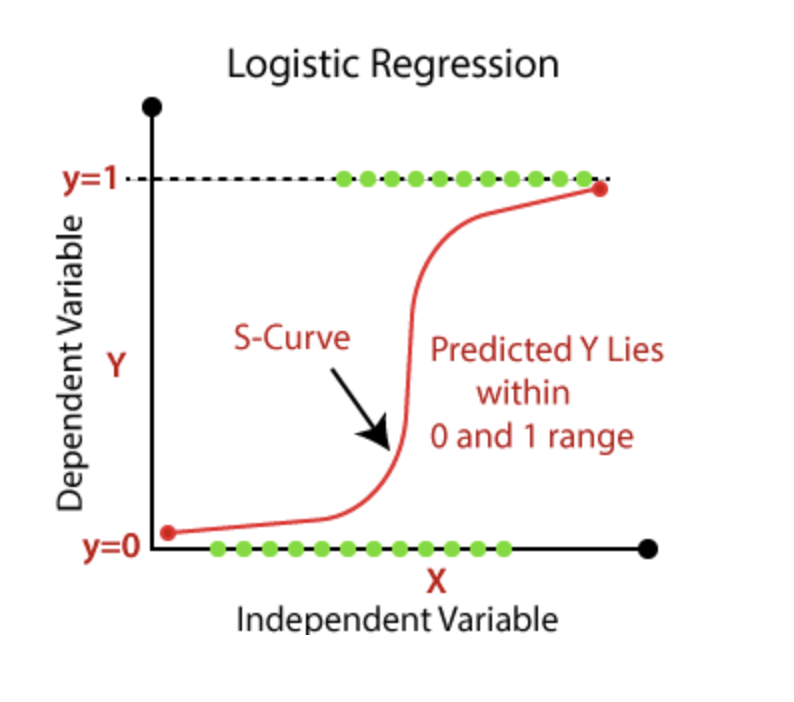

Before getting into more complex models, we want a simple baseline to be able to make comparisons with. When it comes to classification problems, *Logistic Regression* is one of the most simple classifier models. 

#### High-Level Overview of Logistic Regression

Logistic Regression is essentially a linear regression that uses some activation function to map values to probabilities. It calculates a linear combination $z$ (which is exactly like a regular linear regression), but then uses an activation function (*sigmoid* for single-class, *softmax* for multi-class) to convert all values to probabilities. 

Once we have our predictions (the probabilities), we compute the loss of each prediction. This *loss* tells us how far off our prediction was, which tells us how much certain weights need to be changed. Then we can use gradient descent to updating our weights and biases and retrain the model.

#### Mathematics behind Logistic Regression

The goal of logistic regression is to model the probability $P(y=k | X)$ that a data point belongs to a specific class $k$, given features $X$. Here are the steps for logistic regression:

1. Compute the linear combination for inputs:
   - First we compute $z$, which represents the inputs for the logistic regression. If $w$ represents the weights for the model, $x$ represents the inputs, and $b$ represents a bias term, then we calculate $z$ as:

$$\begin{equation*}
    z = w^Tx + b
\end{equation*}$$

   - This is similar to a linear regression, combining feature weights with inputs.

2. Apply Sigmoid (or Softmax for multi-class classification)
   - We can transform $z$ into probabilities using either the *sigmoid* or *softmax* functions:
  
$$\begin{equation*}
    \hat{y} = \sigma(z) \ \ \text{or} \ \ P(y=k | X) = \frac{e^{w^T_kx+b_k}}{\sum^K_{j=1}e^{w^T_kx+b_j}}
\end{equation*}$$

3. Compute Loss:
   - We can calculate the **cross-entropy loss** for optimization:

$$\begin{equation*}
    \text{Loss} = -\frac{1}{N}\sum^N_{i=1}\sum^K_{k=1}y_{i,k}\log{\hat{y_{i,k}}}
\end{equation*}$$

   - where $y_{i,k}$: Actual class labels (1 if $i$ belongs to class $k$, otherwise 0)
   - where $\hat{y_{i,k}}$: Predicted probability for class $k$.

4. Gradient Descent
   - Minimize the loss by updating weights $w$ and biases $b$ using gradients:
  
$$\begin{equation*}
    w \leftarrow w - \alpha\frac{\partial\text{Loss}}{\partial w}
\end{equation*}$$

   - where $\alpha$: Learning rate. A hyperparameter set by the researcher to influence the speed at which the model trains.

#### Creating our Logistic Regression Model

Let's briefly go over the steps our code will follow for creating the logistic regression model:

1. Define the Model

We will be using the logistic regression model from the `scikit-learn` package for Python. Since this is a multi-class classification problem (10 possible classifications for digits 0-9), a multinomial logit function will work better for this model.

2. K-Folds Cross-Validation

K-fold cross-validation divides the training data into $k$ subsets:

- For each fold, one subset is used for validation, and the remaining $k - 1$ subsets are used for training.
- This process is repreated $k$ times, and the model's performance is averaged across the folds.
- *NOTE:* We will not be using K-Folds for the logistic regression model, but it'll be used in future models.

**Why use K-Folds Cross-Validation?**

- By measuring the model's performance across a larger sample size of tests, we can reduce the variance in the model's evaluation.
- This also ensures that every data point is used for **both** training and validation.

3. Hyperparameter Tuning

Logistic regression has little to no hyperparameters that need to be tuned, unlike more complicated models like neural networks. For the MNIST data, we're using multinomial logistic regression from the `scikit-learn` package. In this case, the only hyperparameter (`C` for the `LogisticRegression` model from `scikit-learn`) is already set by default with our `solver = 'lbfgs'` argument. For future models in this notebook, we will use k-folds cross-validation to tune hyperparameters to improve our models.

Now let's write the code for each step, using comments to clarify what we're doing along the way:
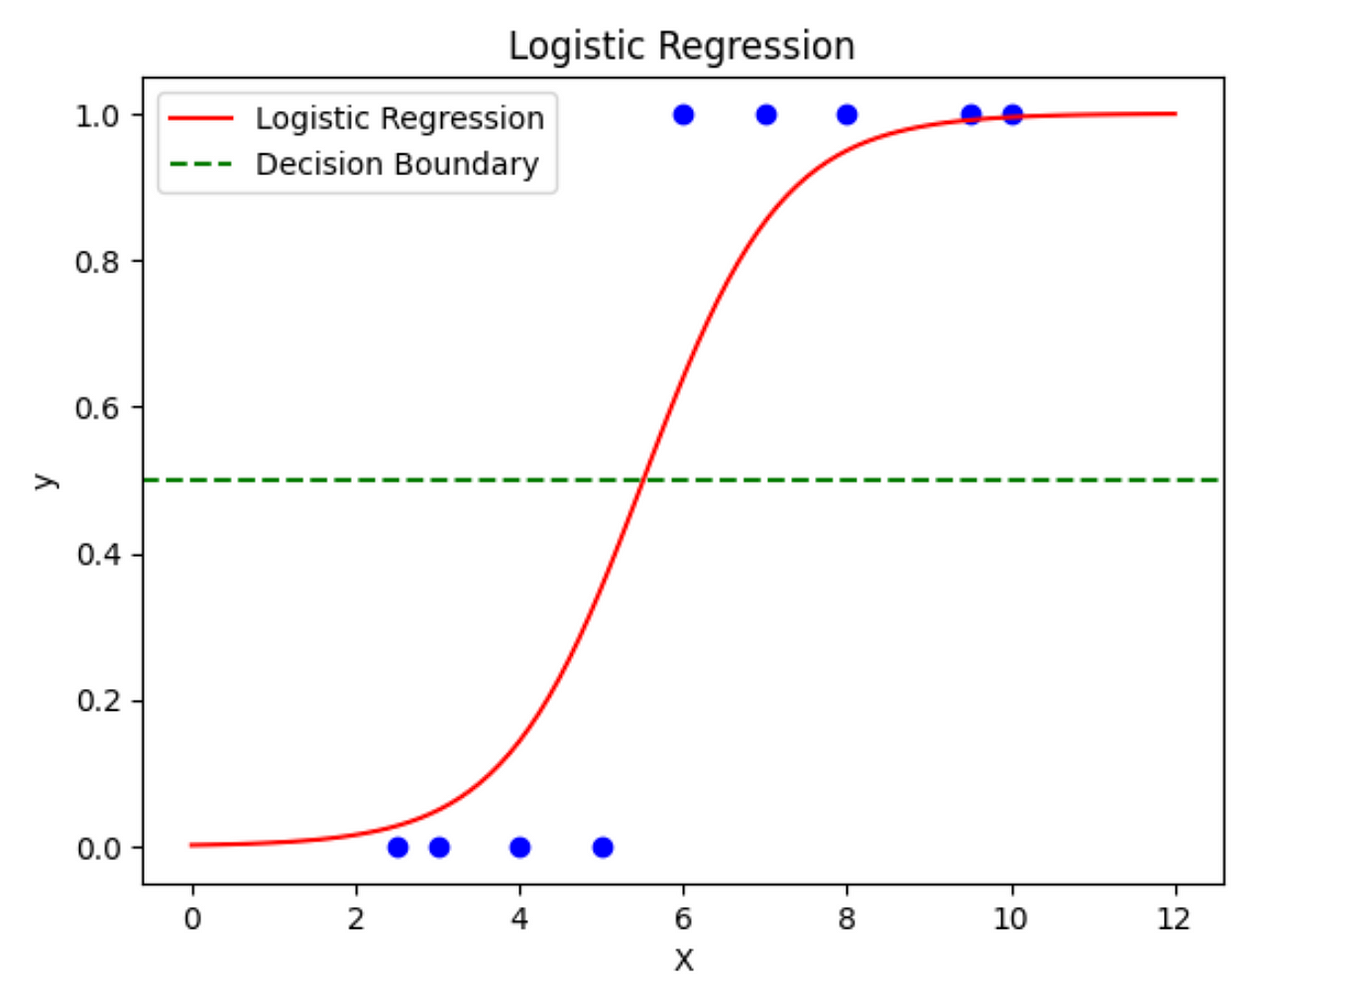

In [ ]:
from sklearn.linear_model import LogisticRegression  # LogReg Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Metrics to help with training

In [ ]:
# Initialize logistic regression model
logistic_model = LogisticRegression(
    max_iter = 1000,               # Max iterations for training
    solver = 'lbfgs',              # Algorithm used for solving, lbfgs is default and good for MNIST
    multi_class = 'multinomial',   # Use multi-class classification
    random_state = 123             # Match random seed for reproducability
)

# Fit the model on training data
logistic_model.fit(X_train, y_train)

In [ ]:
# Import seaborn to visualize confusion matrix
import seaborn as sns

# Make predictions on validation set
y_pred = logistic_model.predict(X_val)

# Calculate model accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Generate confusion matrix
logistic_cm = confusion_matrix(y_val, y_pred)

# Function to visualize a given confusion_matrix as a heatmap
def plot_cm(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = range(10), yticklabels = range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for Logistic Regression model
plot_cm(logistic_cm)

Above, we have the results of our Logistic Regression model. Note that we used the `lbfgs` solver for our algorithm, which is the default and is good for datasets similar to MNIST. 

From our accuracy score, we can see that our Logistic Regression model had 92% accuracy on the validation data. Underneath, we have our classification report, which details the following metrics for our model:

- **Precision:** The percent of correct predictions out of all predictions for that class. For example, 95% of the 0's in our MNIST dataset were correctly identified, while 89% of the 9's in our dataset were correctly identified.
- **Recall:** The percent of actual digits that were correctly recognized within a class. For example, 95% of our 0 predictions were correct (that's our precision), but 96% of the 0's in the dataset were correctly identified. (that's our recall)
- **F1-Score:** Simply combines the *precision* and *recall* metrics as a harmonic mean. The average F1-Score for this model is 91%, which is fairly high. This means our model balances precision and recall well, and is good at minimizing **both** false positives and false negatives.
- **Support:** This is simply the sample size of that particular class in the dataset. In our validation set, we had 949 1's, 800 5's, etc.

Below the classification report, we have what's called a **Confusion Matrix**. This is simply a matrix that compares the number of actual values to the number of predicted values. We can see that the diagonal is mostly high values, and this is because our model had high accuracy. To interpret a cell, look at the 'predicted' and 'actual' values. The first cell tells us that out of all the 0's in the dataset, 756 were correctly identified as zeroes, 3 were incorrectly identified as two's, 1 was incorrectly identified as a 3, and so on. A confusion matrix allows us to quickly see which classes were the hardest to identify. According to our plot above, the digits 2, 3, and 8 seemed especially hard for our model. This is likely due to the fact that 3 and 8 have loops, and 2 has multiple common ways of writing it. 

To finish off our logistic regression model, let's have it make predictions on our testing data, and we'll output a submission file with the predictions. We won't be able to check our accuracy within this notebook, but you can recreate the submission file and upload it to Kaggle if you wish to try it yourself. (Note 1/9/25: This model had an accuracy of 91.732% when submitted to the MNIST competition)

In [ ]:
# Make predictions on our testing set
X_test = test / 255.0
y_logistic_pred = logistic_model.predict(X_test)

# Create submission DataFrame
logistic_submission = pd.DataFrame({
    "ImageId": range(1, len(y_logistic_pred) + 1),
    "Label": y_logistic_pred
})

# Save submission to CSV and output it
logistic_submission.to_csv("logistic_regression_submission.csv", index = False)
print("Submission file for logistic regression model created successfully!")

We are now officially finished with our first and simplest model, Logistic Regression.

### Model #2: Support Vector Machines (SVM)

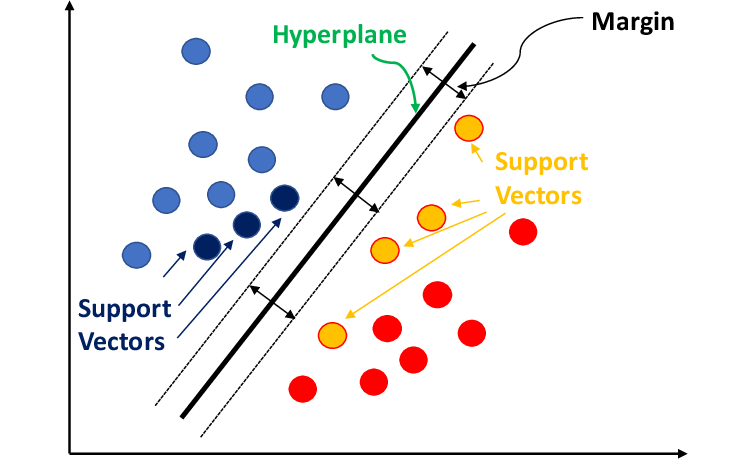

Support Vector Machines (SVM) are another classification algorithm. This model plots our features in a multi-dimensional space, and draws a *hyperplane* as a boundary between two groups of points. The easiest way to explain this is with an example.

#### High-Level Overview of SVM

In the above image, we have *blue* and *red* dots. We want to draw a single line (with some width we call the **margin**) that can separate these groups of dots. That way, if we put a new dot on the graph, we can immediately tell what color the dot should be. Now imagine that instead of drawing a 1-dimensional line in a 2-dimensional feature space, we draw a $n-1$ dimensional hyperplane within a $n$-dimensional feature space, and it's the same general concept.

The named *support vectors* are the dots that are the closest to our hyperplane. We call them support vectors because they are the most important data points for deciding where our boundary goes. This means that certain dots (the support vectors) will have a lot of control over our model, while other dots (ones farther away from the boundary) will have less control over the model. For our MNIST data, we have $k=10$ classes, one for each digit 0-9. However, we have 784 features, one for each pixel. So for this dataset, we will plot the feature vectors in a 784-dimensional vector space, and draw some sort of hyperplane to separate each image into some digit class.

One thing to note before getting into the mathematics is that SVM can only compare two classes at one time. Since our MNIST data has 10 classes, we have two options:

- **One-vs-One (OvO):** Train a separate binary classifier (hyperplane) for each pair of classes. So we'd have unique hyperplanes for 0's vs. 1's, 0's vs. 2's, etc.
- **One-vs-Rest (OvR):** Train one binary classifier (hyperplane) for each class. We'd have 10 hyperplanes: 0's vs. not 0's, 1's vs. not 1's, etc.

For the mathematics behind the model, we'll go over how a single binary classifier is trained. We'll discuss which of the above approaches we'll use for the MNIST data later in the notebook.

#### Mathematics behind SVM

Given labeled data points $(x_i, y_i)$ where:

- $x_i$: Feature vector of the $i$th data point. (in this case, a single MNIST image's pixel values)
- $y_i$: Class label of the $i$th data point. ($+1$ or $-1$)

The goal of SVM is to find a hyperplane $w \cdot x + b = 0$ such that:

- The hyperplane maximizes the margin between the two classes.
- The hyperplane minimizes classification errors.

Here are the steps to a Support Vector Machines algorithm:

1. Define a hyperplane in an $n$-dimensional space as $w \cdot x + b = 0$ where

- $w$: Weight vector perpendicular to the hyperplane. (These weights are changed during training)
- $b$: Bias term that shifts the hyperplane. (This is also updated during training)

The decision boundary (or hyperplane) separates the data into two regions:

$\begin{align*}
    \text{Class}+1: \ \ &w \cdot x + b > 0 \\
    \text{Class}-1: \ \ &w \cdot x + b < 0
\end{align*}$

2. Now we must define and maximize the margin of the decision boundary. If our weights $w$ are normalized, the margin for a point $(x_i, y_i)$ is defined as:

$\begin{equation*}
    \text{Margin} = \frac{1}{\lVert w \rVert}
\end{equation*}$

We must make this margin as large as possible while still ensuring that our points are correctly classified. This is true if the following statement holds:

$\begin{equation*}
    y_i \cdot (w \cdot x_i + b) \geq 1 \ \ \text{for all } i
\end{equation*}$

Using some calculus that we won't get into the details for, we can maximize the margin by minimizing $\frac{1}{2}\lVert w\rVert^2$. Now, our optimization problem is:

$\begin{equation*}
    \text{min}_{w, b}\frac{1}{2}\lVert w\rVert^2 \ \ \ \text{ subject to } \ \ \ y_i(w \cdot x_i + b) \geq 1
\end{equation*}$

3. Depending on the dataset, it's often **impossible** to fully separate classes with a decision boundary. We can allow for some small amount of misclassifications using *slack variables* denoted $\xi_i \geq 0$. Additionally, we can include our regularization parameter $C$, which will help control how much misclassifications affect our decision boundary. Now, our optimization problem is:

$\begin{equation*}
    \text{min}_{w, b, \xi}\frac{1}{2}\lVert w\rVert^2 + C\sum_{i=1}^n \xi_i \ \ \ \text{ subject to } \ \ \ y_i(w \cdot x_i + b) \geq 1
\end{equation*}$

4. Next, we can apply a **kernel function** to map our data to a higher dimension if it is not linearly separable. Note, this is **NOT** required for every SVM model, but will be necessary for our MNIST data since it's not likely that 784 features will be linearly separable right away. For this project we will be using the **Radial Base Function (RBF)** as our kernel. If $\gamma$ is a free hyperparameter that can be tuned, the RBF function is as follows:

$\begin{equation*}
    K(x_1, x_2) = \text{exp}(-\gamma\lVert x_1 - x_2\rVert^2)
\end{equation*}$

5. Lastly, it's time to rewrite our final dual optimization problem. We're attempting to minimize our $\frac{1}{2}\lVert w\rVert^2$. If we use the Lagrangian, we can train our model and get a prediction function:

$\begin{equation*}
    f(x) = \sum_{i \in \text{support vectors}} \alpha_i y_i K(x_i, x) + b
\end{equation*}$

The sign of our prediction function $f(x)$ determines the class. If $f(x_i) > 0$, then $x_i$ is in the class $+1$. Similarly, if $f(x_i) < 0$, then $x_i$ is in the class $-1$. We can repeat this as needed for OvO or OvR approaches for multi-class classification problems like MNIST.

#### Creating our SVM Model

Now we are ready to actually implement our SVM model with Python. There are a few important details about how we're implementing our code:

- We will be using the OvR (One-vs-Rest) algorithm for this model. This is because we will only have to train $k=10$ decision boundaries, instead of the $k=45$ decision boundaries required by the OvO (One-vs-One) algorithm. SVM is already a computationally complex model, so we're doing this to keep our training from going too slow.
- We're going to use a *cross-validated grid search* `GridSearchCV` to tune our hyperparameters $C$ and $\gamma$. As a reminder, $C$ represents our regularization parameter and $\gamma$ is a hyperparameter used to tune our kernel function.

Since this is our first time tuning hyperparameters, let's break it down step-by-step. First, we must define what's called a **parameter grid**. This is a Python dictionary where the keys are the hyperparameters we want to tune, and the values are possible values that we want to test. Let's define our parameter grid for this SVM model:

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define SVM parameter grid (THIS WAS UPDATED AFTER TRAINING)
svm_param_grid = {
    'C': [10],         # Best C was 10
    'gamma': [0.01],   # Best gamma was 0.01
    'kernel': ['rbf']  # Using RBF kernel for this model
}

Note that for `kernel`, we only listed `rbf`. This is because we're only using the Radial Base Function for our SVM model, we don't need to test any other kernels. Now, we can use `GridSearchCV` to search the best values for $C$ and $\gamma$:

In [ ]:
from sklearn.svm import SVC

# Initialize the SVM model
svm = SVC(
    decision_function_shape = 'ovr',  # Use One-vs-Rest algorithm for multi-class classification
    random_state = 123                # Match random seed for reproducability
)

# Define the SVM grid search for optimal hyperparameters C and gamma
svm_grid_search = GridSearchCV(
    estimator = svm,             # Use SVM model for grid search
    param_grid = svm_param_grid, # Use our defined parameter grid
    cv = 3,                      # Use k = 3 folds for cross-validation
    scoring = 'accuracy',        # Use accuracy as scoring metric
    verbose = 2,                 # Show search progress in terminal
    n_jobs = -1                  # Use all available CPUs for parallel processing
)

In [ ]:
# Fit our svm_grid_search to our training data
svm_grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = svm_grid_search.best_params_
svm_model = svm_grid_search.best_estimator_

# Print optimal parameters
print(f'Best Parameters: {best_params}')

Now that we have our optimal parameters $C = 10$ and $\gamma = 0.01$, we can make predictions and evaluate our SVM model. Luckily, `GridSearchCV` saves the best model in its results, so we defined our `svm_model` as the `best_estimator_` of our `GridSearchCV` object. Below, let's make our predictions and evaluate our model's performance using a classification report and confusion matrix:

In [ ]:
# Make predictions using SVM model
y_svm_pred = svm_model.predict(X_val)

# Evaluate accuracy
accuracy = accuracy_score(y_val, y_svm_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_val, y_svm_pred))

# Create and plot confusion matrix
svm_cm = confusion_matrix(y_val, y_svm_pred)
plot_cm(svm_cm)

One thing to note about the above training process is that it took a **long** time to run. The cell where we ran `svm_model.fit(X_train, y_train)` took several hours to run, and this is likely because we were training our model 36 different times. We had 12 possible combinations of hyperparameters, and each one was being validated through 3 folds. This resulted in $12 \times 3$ different training cycles, with SVM already being a computationally heavy algorithm. **For the above training cell, I've changed the parameter grid to only have the optimal values. This is so that training is not fully ran every time we reload the notebook.**

Looking at our above results, this model performed fantastically compared to our logistic regression. We had a model accuracy of 98%, with the average metrics from our classification report all being 98% as well. Looking at our confusion matrix, our model struggled with falsely identifying 9's as 4's mostly. This makes sense as both 9 and 4 are some sort of "loop" with a smaller single segment underneath it. There's a good chance that our model is struggling to determine which 'loops' or 'segments' belong to a 9 or 4.

Since we've confirmed that our model performs well, let's go ahead and generate a submission file by making predictions on our test set. Just like the previous model, you are welcome to download the submission file that's generated and submit it yourself to see how well it performs. (Note 1/9/25: This model had an accuracy of 97.875% when submitted to the MNIST competition)

In [ ]:
# Make predictions on our testing set
y_svm_pred = svm_model.predict(X_test)

# Create submission DataFrame
svm_submission = pd.DataFrame({
    "ImageId": range(1, len(y_svm_pred) + 1),
    "Label": y_svm_pred
})

# Save submission to CSV and output it
svm_submission.to_csv("svm_regression_submission.csv", index = False)
print("Submission file for SVM model created successfully!")

We are now officially finished with our 2nd model, Support Vector Machines.

### Model #3: Random Forest Classifier

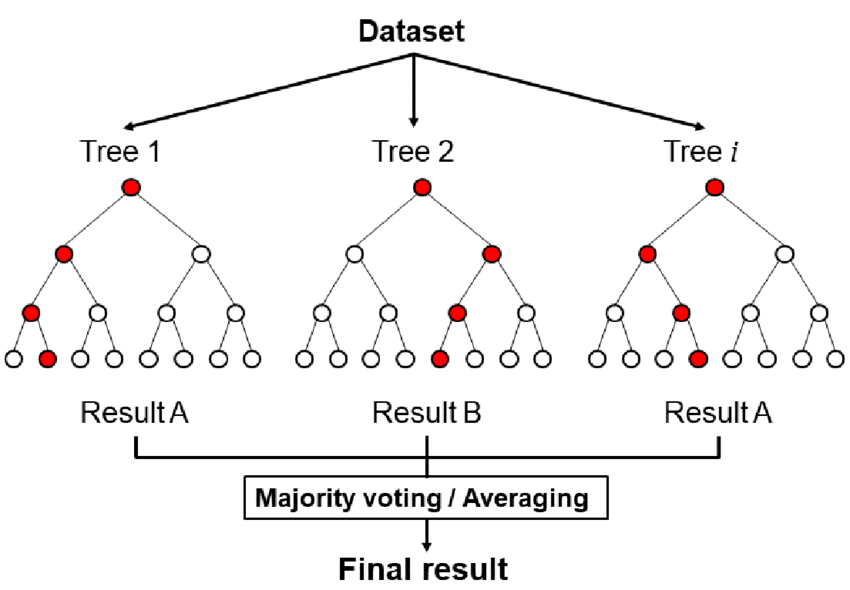

A random forest classifier is a model that actually takes advantage of another ML algorithm: **decision trees**. Simply put, a **Random Forest** is a set of $i$ decision trees. We record the results of each individual decision tree, and then average the results to get the overall prediction for the Random Forest. Let's discuss this in a bit more detail.

#### High-Level Overview of Random Forest Classifiers

Random forest classifiers are our first example of **Ensemble Learning**. This is a term in machine learning to refer to when multiple weak learners (like decision trees) are combined to make a stronger, single model. For example, imagine you were trying to learn what the best Chinese restaurant is in your city. You wouldn't just ask one person's opinion, you would get as many opinions as you can to feel more confident in your choice. This is analogous to using an entire random forest of decision trees instead of just using a single decision tree.

Here are some of the key ideas in Random Forests:

1. **Bootstrap Aggregation (Bagging)**: Each decision tree in a random forest is trained on a *random subset* of our training data. This data is sampled with replacement over and over for each new decision tree. This can help introduce variability as well as reduce risk of overfitting.
2. **Feature Randomness**: At each split in a single decision tree, only a random subset of features is considered. This keeps features from affecting other features too much in the training process, and can make the model more robust overall.
3. **Voting**: When making its final prediction, a random forest makes a guess based on the average value of all the individual decision trees.
    - For classification problems (like MNIST), the random forest predicts whichever class was predicted by the **most decision trees**.
    - For regression problems (like predicting a number value), the random forest predicts the average of all decision tree predictions.

#### The Mathematics behind Random Forests

Unlike our last two models, there is not a lot of heavy mathematics that goes into a Random Forest model. Each individual split of a decision tree determines what split would be the best for **maximizing the separation of the classes**. At each node, the tree evaluates splits using some metric. Some common examples are **Gini Impurity** $G = 1 - \sum_{i=1}^C p_i^2$ (where $C$ is the number of classes), or **Entropy** $H = -\sum_{i=1}^C p_i \text{log}_2(p_i)$. 

Additionally, random forests often using **Bootstrapping**, which is taking repeated samples of a single dataset using replacement. Because of the way bootstrapping is done, we end up with about 1/3 of our original data never being used for training. This is called the **Out-of-Bag (OOB) Sample**, and can be used for validating a model instead of having to create a separate validation set.

#### Creating a Random Forest Classifier

Below, we have the code blocks for creating and evaluating our random forest classifier model. I will be using `GridSearchCV` to find the optimal values for the following hyperparameters:

1. **Number of Trees (`n_estimators`):** This hyperparameter specifies how many decision trees are used for the random forest. Most of the time, more trees leads to a higher-performing model. However, too many trees can cause the model to overfit. Usually higher values will almost always give better results, will have diminishing returns as the number of trees goes up. To avoid taking forever for our model to train, we'll be testing values `[100, 200, 500]`.
2. **Maximum Depth of Trees (`max_depth`):** This hyperparameter specifies how many splits each decision tree will have, or how "deep" each tree will go. Trees that are too shallow may underfit, while trees that are too complex may overfit. We will test values `[10, 20, None]`, where `None` means the trees will grow until every leaf is pure.

Let's create our model, using `GridSearchCV` to find optimal values for `n_estimators` and `max_depth`:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
rf_param_grid = {
    'n_estimators': [500],  # Best value was 500
    'max_depth': [None]     # Best value was None
}

In [ ]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(
    random_state = 123   # Matches random seed for reproducability
)

# Define GridSearchCV object
rf_grid_search = GridSearchCV(
    estimator = rf,              # Use Random Forest as model
    param_grid = rf_param_grid,  # Use RF parameter grid
    cv = 3,                      # k = 3 folds for cross-validation
    scoring = 'accuracy',        # Use accuracy as scoring metric
    verbose = 2,                 # Show progress during training
    n_jobs = -1                  # Use all possible CPU cores
)

In [ ]:
# Fit the grid search to training data
rf_grid_search.fit(X_train, y_train)

# Extract best parameters and model
rf_best_params = rf_grid_search.best_params_
rf_model = rf_grid_search.best_estimator_

# Print best hyperparameters
print(f'Best Parameters: {rf_best_params}')

According to our GridSearch above, our optimal hyperparameters are `n_estimators = 500` and `max_depth = None`. This is not surprising, as the model's performance will logically get better as the number of trees and tree depth increases. However, we could be overfitting our model too much. Let's use these values for our Random Forest to make predictions on our validation set:

In [ ]:
# Make predictions on validation set
y_rf_pred = rf_model.predict(X_val)

# Calculate and print model accuracy
rf_accuracy = accuracy_score(y_val, y_rf_pred)
print(f'Validation Accuracy: {rf_accuracy:.2f}')

# Generate and print classification report
print('Classification Report:')
print(classification_report(y_val, y_rf_pred))

# Generate and plot confusion matrix
rf_cm = confusion_matrix(y_val, y_rf_pred)
plot_cm(rf_cm)

Even though we went with the maximum values for `n_estimators` and `max_depth`, our model still performed very well with about 97% accuracy. Across the board, all evaluation metrics were 1% less on average than they were with our SVM model, but still overall very good at 97% as well. One thing that's interesting about our confusion matrix is we have more "problem pairs" of digits than we did with the SVM model. Our 7's are being falsely identified as 2's, our 5's are being falsely identified as 3's, and our 9's are being falsely identified as 4's, just like the SVM model. This could lead to our slighly lower accuracy, but the model still performed very well overall. 

Now, let's make predictions on our testing set and generate our CSV submission file. (When this model was submitted to the competition, it achieved 96.55% accuracy)

In [ ]:
# Make predictions on our testing set
y_rf_pred = rf_model.predict(X_test)

# Create submission DataFrame
rf_submission = pd.DataFrame({
    "ImageId": range(1, len(y_rf_pred) + 1),
    "Label": y_rf_pred
})

# Save submission to CSV and output it
rf_submission.to_csv("rf_regression_submission.csv", index = False)
print("Submission file for Random Forest Classifier model created successfully!")

And now we're finished with our 3rd model, Random Forest Classifiers.

### Model #4: Multilayer Perceptron Classifier

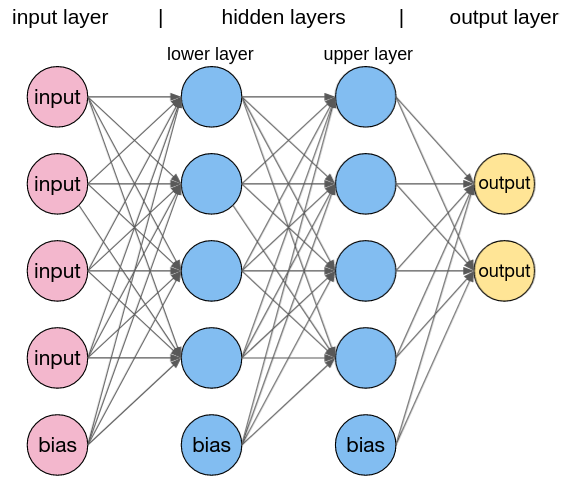

#### High-Level Overview of Multilayer Perceptrons

For our 4th model, we'll be taking a look at the **Multilayer Perceptron Classifier**. This is a fancy name for a basic *neural network*. Based on its namesake, a neural network functions very similarly to a human brain. It has multiple layers of *nodes*, which are similar to neurons in the brain. Each node in a layer is connecte to every other node in the adjacent layers, like the diagram above. When one node activates, it has some ripple effect on all nodes in the next layer. 

The connections in between the nodes are referred to as *weights*. These are what we're calculating when we train a neural network. As we go through training cycles, we try random values for the weights at first. Then we use backpropagation to calculate how we need to change the weights in order for our model to perform better. (more specifically, it's how we need to change the weights in order for our model's error to be minimized)

#### Mathematics Behind Multilayer Perceptrons

The mathematics behind neural networks is much more complex than any other model we've covered in this notebook. It takes a strong combination of linear algebra and multivariate calculus to be comfortable with the inner workings of a neural network. Since this notebook is more focused on the code implementations of each model, I will not go into the mathematical details here.

**NOTE:** If you're interested in a deep-dive into the mathematics, check out the file `MathBehindNeuralNetworks.pdf` in the GitHub repository ![Multilayer Perceptron](https://github.com/jahess150/MultilayerPerceptron). This is an implementation of a multilayer perceptron from the ground up using Python. At the time of writing the script itself is not complete, but I've included a LaTeX document detailing the math going into the model. 

#### Creating a Multilayer Perceptron Classifier

Similar to our other models, we have to first tune several hyperparameters for our multilayer perceptron. We will start by tuning the following hyperparameters:

1. `hidden_layer_sizes`
   - Controls how many nodes and how many layers are in the network.
   - `(64,)` would mean one layer with 64 nodes, while `(128, 64)` would mean two layers with 128 and 64 nodes respectively, etc.
   - We want to start simple (one layer, less nodes) and increase the complexity as needed.

2. `activation`
   - This hyperparameters sets which *activation function* is used to "activate" the nodes during the forward propagation process.
   - We will be testing two possible functions: `relu` and `tanh`.

3. `alpha`
   - Sets the L2 Regularization parameter. Similar to our other models, this prevents overfitting by penalizing large weights.
   - For a multilayer perceptron, we will start with a small range `[0.0001, 0.001, 0.01]`.

Let's go ahead and set up our parameter grid, tune our hyperparameters, and evaluate our model:
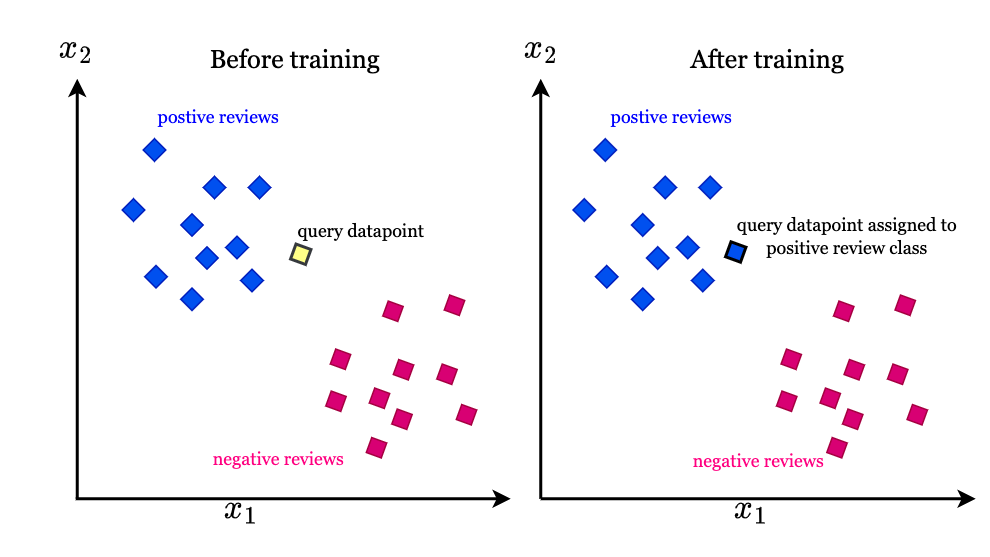

In [ ]:
from sklearn.neural_network import MLPClassifier

# Define parameter grid (NOTE: Optimal values are set)
mlp_param_grid = {
    'hidden_layer_sizes': [(256, 128, 64)],
    'activation': ['relu'],
    'alpha': [0.01],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.02],
    'batch_size': [64]
}

# Initialize MLP Classifier
mlp = MLPClassifier(
    max_iter = 300,         # 300 iterations allows for MLP to converge
    random_state = 123,     # Matches seed for reproducability
    early_stopping = True   # Stops training early if performance doesn't improve
)

# Initialize GridSearchCV
mlp_grid_search = GridSearchCV(
    estimator = mlp,              # Use MLP model
    param_grid = mlp_param_grid,  # Use MLP parameter grid
    cv = 3,                       # k = 3 folds for cross-validation
    scoring = 'accuracy',         # Use accuracy as scoring metric
    verbose = 2,                  # Show progress during training
    n_jobs = -1                   # Use all available CPU cores
)

In [ ]:
# Tune the MLP's hyperparameters
mlp_grid_search.fit(X_train, y_train)

# Extract best parameters and model
mlp_best_params = mlp_grid_search.best_params_
mlp_model = mlp_grid_search.best_estimator_

# Print out best hyperparameters
print(f'Best Parameters: {mlp_best_params}')

In [ ]:
# Predict on validation set
y_mlp_pred = mlp_model.predict(X_val)

# Calculate and print accuracy
mlp_accuracy = accuracy_score(y_val, y_mlp_pred)
print(f'Validation Accuracy: {mlp_accuracy:.2f}')

# Generate and print classification report
print('Classification Report:')
print(classification_report(y_val, y_mlp_pred))

# Generate and plot confusion matrix
mlp_cm = confusion_matrix(y_val, y_mlp_pred)
plot_cm(mlp_cm)

Multilayer Perceptrons are very complex models, and can take more hyperparameter tuning than other models comparatively. We will do multiple training cycles, and will document the results of each one here. (**NOTE:** The code will not reflect each cycle. I will change the code, but you can see the results of each below)

---

**Training Cycle 1**

*Validation Set Accuracy:* 96%

Hyperparameters tuned:

- `activation: ['relu', 'tanh']` (Result: `relu`)
- `alpha: [0.0001, 0.001, 0.01]` (Result: 0.01)
- `hidden_layer_sizes: [(64,), (128,), (256,)]` (Result: (256,))

Since we now know `relu` will be the better activation function, we don't need to tune that hyperparameter anymore. Since the first layer works better with more nodes (as expected), we will try `(256, 64)` and `(128, 128)` for two-layer architectures next. Our goal is to figure out whether we want more nodes in the first layer and let the second layer refine the results, or if we want a balanced architecture between both layers. 

Additionally, we'll widen our search for alpha slightly. We will test `[1e-5, 0.01, 0.1]` to see if we need to go much larger or lower for our alpha. 

Lastly, we'll tune a new hyperparameter, `learning_rate_init`. This sets our initial learning rate $\alpha$, which controls how fast our neural network is trained. The default is `0.001`, so we'll test `[0.0001, 0.001, 0.01]` to get an idea of which learning rate works best. 

*Reminder: The code will change after each training cycle. To recreate previous training cycles, simply change the parameter grid to match the details above.*

---

**Training Cycle 2**

*Validation Set Accuracy:* 98%

Hyperparameters tuned:

- `alpha: [1e-5, 0.01, 0.1]` (Result: 0.01)
- `learning_rate_init: [0.0001, 0.001, 0.01]` (Result: 0.001)
- `hidden_layer_sizes: [(256, 64), (128, 128)]` (Result: `(256, 64)`)

Our accuracy improved by 2%, likely due to our network now having two layers of nodes. The learning rate still performs best at its default value of `0.001`, and the optimal alpha hasn't changed. 

With our third training cycle, we're going to take a look at some different hyperparameters. We're going to continue tweaking our architecture. We're going to test three network architectures: `[(256, 64), (256, 128), (256, 64, 32)]`. It's possible that using three layers could cause some overfitting, so we'll still compare it to two versions with two layers.

We will also try changing the `batch_size`. The default is `min(200, n_samples)`, but we'll try the values `[64, 128, 256]` to get a wider range of results. 

Lastly, we'll try changing our learning rate strategy. We're going to keep the value the same at `0.001`, but we'll try both `constant` and `adaptive` learning strategies. (`constant` is the default, while `adaptive` adjusts the learning rate based on validation performance). 

---

**Training Cycle 3**

*Validation Set Accuracy:* 98% (same as cycle 2, but slightly better performance, see confusion matrix)

Hyperparameters tuned:

- `hidden_layer_sizes: [(256, 64), (256, 128), (256, 64, 32)]` (Result: `(256, 64, 32)`)
- `batch_size: [64, 128, 256]` (Result: 64)
- `learning_rate: ['constant', 'adaptive']` (Result: `constant`)

For our final round of hyperparameter tuning, we will focus on refining hyperparameters that have already been tuned. Since the model seems to work well with the three-layer architecture, we will test `[(256, 64, 32), (256, 128, 32), (256, 128, 64)]` for other three-layer architectures.

Additionally, we'll continue fine-tuning our `learning_rate_init` (values `[0.0005, 0.001, 0.002]` and our `alpha` (values `[0.0075, 0.01, 0.0125]`) to help avoid overfitting our model. As the architecture complexity goes up, we need to be more mindful of the risk of overfitting. 

---

**Training Cycle 4**

*Validation Set Accuracy:* 98% (same as cycles 2/3, not much performance improvement from cycle 3)

Hyperparameters tuned:

- `hidden_layer_sizes: [(256, 64, 32), (256, 128, 32), (256, 128, 64)]` (Result: `(256, 128, 64)`)
- `alpha: [0.0075, 0.01, 0.0125]` (Result: 0.01)
- `learning_rate_init: [0.0005, 0.001, 0.002]` (Result: 0.02)

As we can see from our accuracy and confusion matrix, we had little to no improvement from training cycle 3 to cycle 4. As such, we'll stop our hyperparameter tuning after cycle 4 and finalize our model.

---

To summarize, here's a table showing all of the hyperparameters that were tuned, and their values through all 4 training cycles:

| Hyperparameter | Cycle 1 | Cycle 2 | Cycle 3 | Cycle 4 | Final Value |
| -------------- | ------- | ------- | ------- | ------- | ----------- |
| `activation` | `relu` |              |               |               | `relu` |
| `alpha` | 0.01 | 0.01 |  | 0.01 | 0.01 |
| `hidden_layer_sizes` | (256,) | (256, 64) | (256, 64, 32) | (256, 128, 64) | (256, 128, 64) |
| `learning_rate_init` | | 0.001 | | 0.02 | 0.02 |
| `learning_rate` | | | `constant` | | `constant` |
| `batch_size` | | | 64 | | 64 |

Now when you look at the `mlp_param_grid` dictionary above, it'll already have the optimal value for each hyperparameter. Feel free to do your own tuning to see what works better!

Now, let's go ahead and actually test our multilayer perceptron against the testing data. Just like we did for our previous models, let's output our submission as a CSV file and upload it to the Kaggle competition. (**NOTE:** This model had an accuracy of 97.32% when uploaded to Kaggle)

In [ ]:
# Make predictions on our testing set
y_mlp_pred = mlp_model.predict(X_test)

# Create submission DataFrame
mlp_submission = pd.DataFrame({
    "ImageId": range(1, len(y_mlp_pred) + 1),
    "Label": y_mlp_pred
})

# Save submission to CSV and output it
mlp_submission.to_csv("mlp_regression_submission.csv", index = False)
print("Submission file for Multilayer Perceptron Classifier model created successfully!")

## 4.) Conclusions

This notebook laid out the process for tuning and refining machine learning models for recognizing handwritten digits from the MNIST dataset. We looked at four models. In order of accuracy, our four models were:

1. **Support Vector Machines (SVM):** Had the highest accuracy score at 97.875%
2. **Multilayer Perceptron Classifier:** Had an accuracy of 97.32%
3. **Random Forest Classifier:** Had an accuracy of 96.55%
4. **Logistic Regression:** Had the lowest accuracy score at 91.732%

Personally, I was surprised to see that SVM model beat the multilayer perceptron in terms of accuracy. There's a chance that having three hidden layers for our MLP could've caused some overfitting, but it's hard to tell unless we delved into it deeper. If you're interested in seeing how neural networks work in more detail, check out my other notebook **PyTorch vs. Keras on MNIST Data** to see two in-depth implementations of multilayer perceptrons using more in-depth Python libraries `Keras` and `PyTorch`. 

Thank you for reading through my notebook! I hope you were able to learn something or feel more confident in your machine learning abilities after finishing this notebook. If you have any questions or suggestions for the notebook, feel free to email me at jahess150@gmail.com.